# Data Understanding and Visualizations.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Required Libraries

In [2]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## 2. Dataset Preparation

### 2.1 Verify Dataset Structure

In [13]:
# Define paths and parameters
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"

img_size = (224, 224)
batch_size = 32

# Get class names
class_names = sorted(os.listdir(train_dir))
if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


### 2.2 Check for Corrupted Images


In [6]:
from PIL import Image, UnidentifiedImageError

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")


No corrupted images found.


### 2.3 Count Class Balance


In [7]:
# Dictionary to store class counts
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)  # Count images in each class

# Print class balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


### 2.4 Select Random Images for Visualization


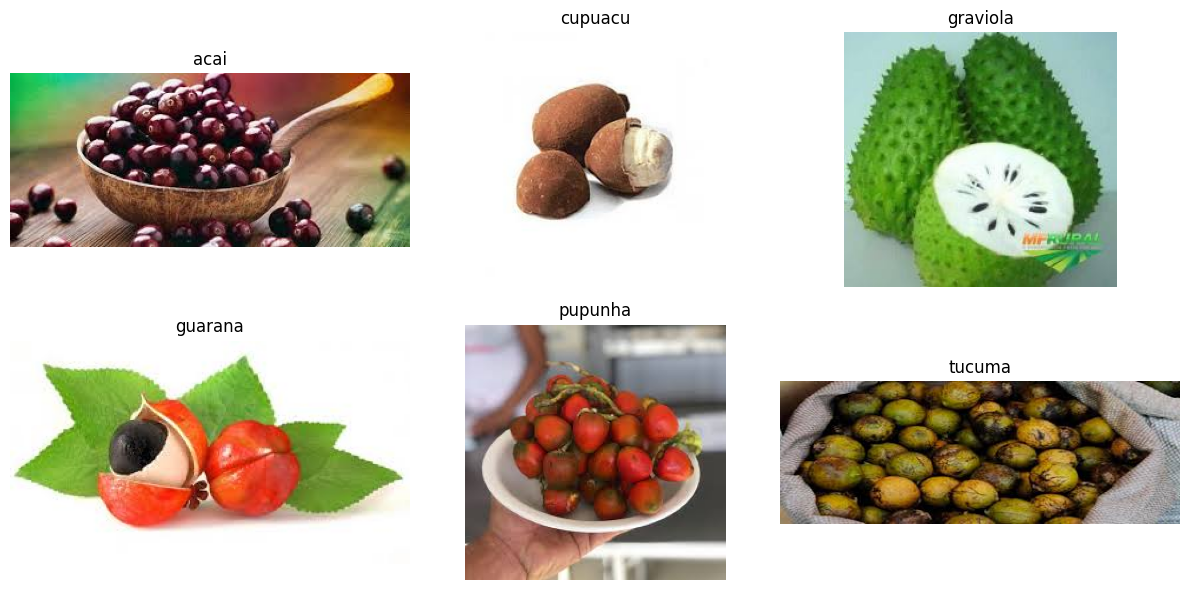

In [8]:
import random

selected_images = []  # Store image paths
selected_labels = []  # Store corresponding class names

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:  # Ensure the class folder is not empty
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

# Display randomly selected images in a grid format
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Determine columns
rows = 2  # Fixed rows for layout

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = plt.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")  # Hide empty subplots
plt.tight_layout()
plt.show()

## 3. Data Generation and Preprocessing

### 3.1 Generate Train and Validation Datasets


In [14]:
# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    seed=1337,
    image_size=img_size,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    test_dir,
    seed=1337,
    image_size=img_size,
    batch_size=batch_size,
)

# Prefetch datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [15]:
# Checking the shape of a batch
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


### 3.2 Visualize Training Dataset


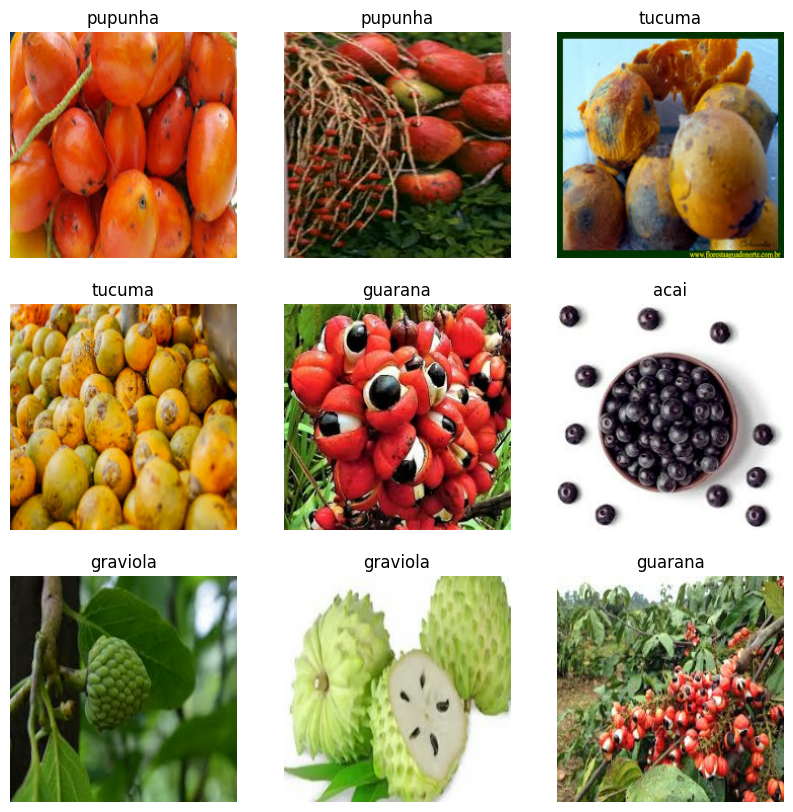

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 3.3 Data Augmentation


In [17]:
# Define the data augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

### Visualize augmented images

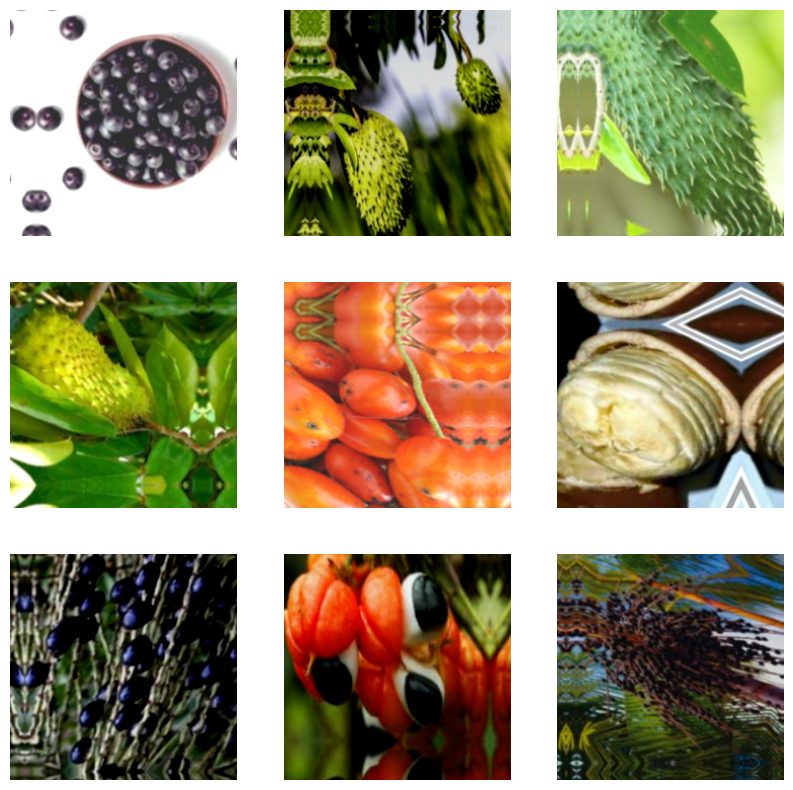

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):  # Take 1 batch from original dataset
    augmented_images = data_augmentation(images)  # Apply augmentations
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    break
plt.show()

## 4. Model Building


### 4.1 Define the CNN Model


In [19]:
from tensorflow.keras.layers import (Lambda, Rescaling, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D)

# Define the model using the Sequential API with a list of layers
model = Sequential([
    # Define the input shape using InputLayer
    Input(shape=(224, 224, 3)),

    # Data Augmentation using Lambda
    Lambda(data_augmentation, input_shape=(224, 224, 3)),

    # Rescaling layer
    Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten before fully connected layers
    Flatten(),

    # Fully Connected Layer 1
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fully Connected Layer 2
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fully Connected Layer 3
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fully Connected Layer 4
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output layer (10 classes)
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

## 5. Training the Model


### 5.1 Add Callbacks


In [20]:
# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                 # Wait for 10 epochs before stopping
    restore_best_weights=True   # Restore weights from the best epoch
)

# Define Learning Rate Reduction on Plateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.5,                  # Reduce learning rate by a factor of 0.5
    patience=3,                  # Wait for 3 epochs before reducing LR
    min_lr=1e-6                  # Minimum learning rate
)

## 5.2 Train the Model


In [21]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,     # Use test_ds for validation
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.2746 - loss: 2.3904 - val_accuracy: 0.1667 - val_loss: 2.2601 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.1810 - loss: 2.6315 - val_accuracy: 0.2667 - val_loss: 2.2346 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.1503 - loss: 2.7083 - val_accuracy: 0.2000 - val_loss: 2.2018 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.1983 - loss: 2.3371 - val_accuracy: 0.2333 - val_loss: 2.1957 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.1670 - loss: 2.8978 - val_accuracy: 0.1333 - val_loss: 2.1847 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.1703 - loss: 2.4329 - val_accuracy: 0.2000 - val_loss: 2.1613 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.1526 - loss: 2.4990 - val_accur

## 6. Evaluate the Model


## 6.1 Plot Training History


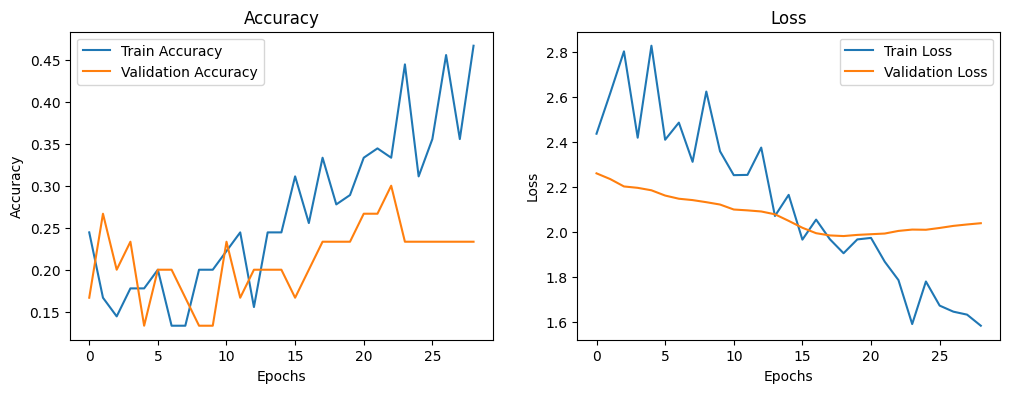

In [22]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Using Keras ImageDataGenerator (Old API)

Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.1826 - loss: 3.3070 - val_accuracy: 0.1667 - val_loss: 2.3902 - learning_rate: 1.0000e-04
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - accuracy: 0.1690 - loss: 3.1684 - val_accuracy: 0.3000 - val_loss: 2.2747 - learning_rate: 1.0000e-04
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/step - accuracy: 0.2685 - loss: 2.4753 - val_accuracy: 0.3667 - val_loss: 2.1586 - learning_rate: 1.0000e-04
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.2680 - loss: 2.8743 - val_accuracy: 0.4333 - val_loss: 2.0501 - learning_rate: 1.0000e-04
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.3032 - loss: 2.3929 - val_accuracy: 0.5000 - val_loss: 1.9455 - learning_rate: 1.0000e-04
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 760ms/step - accuracy: 0.4138 - loss: 2.0049 - val_accuracy: 0.5333 - val_loss: 1.8479 - learning_rate: 1.0000e-04
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 867ms/step - accuracy: 0.4800 - loss: 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Re-evaluated Model Performance:
              precision    recall  f1-score   support

        acai       1.00      0.80      0.89         5
     cupuacu       0.83      1.00      0.91         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      1.00      1.00         5
     pupunha       0.83      1.00      0.91         5
      tucuma       1.00      0.80      0.89         5

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



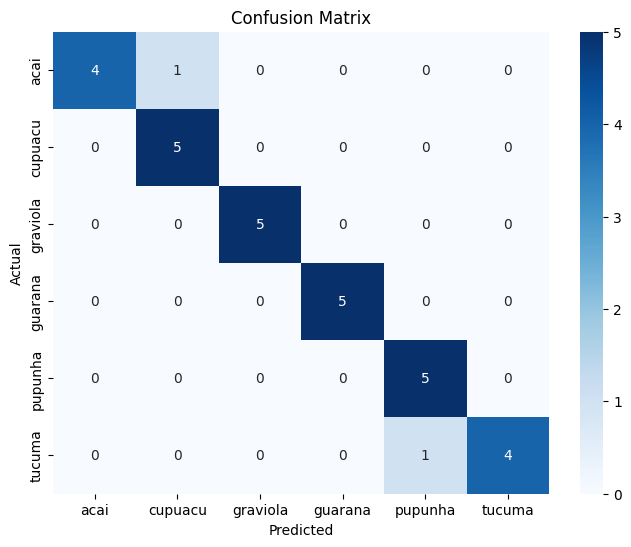

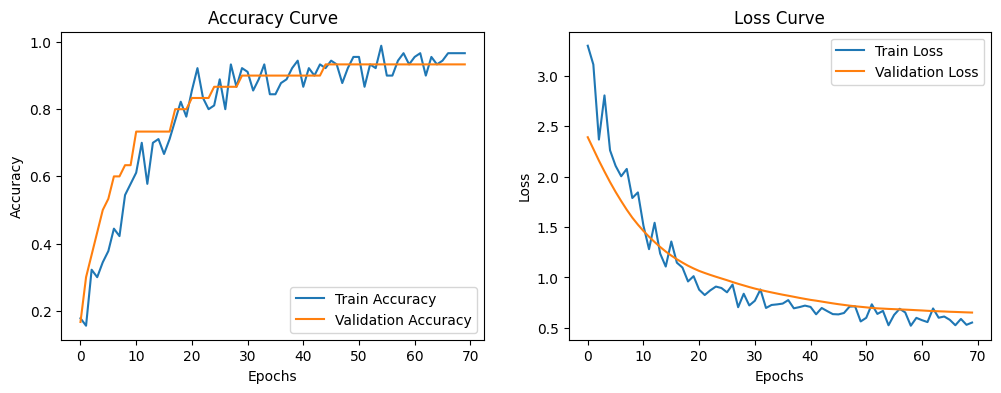

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initial layers

# Define Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train Model
history = model.fit(train_data, validation_data=test_data, epochs=70, callbacks=[early_stopping, lr_scheduler])

# Save the trained model
model.save("fruit_classification_model_v2.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model("fruit_classification_model_v2.h5")

# Re-evaluate the model
y_true = test_data.classes
y_pred = np.argmax(loaded_model.predict(test_data), axis=1)
class_labels = list(test_data.class_indices.keys())

print("Re-evaluated Model Performance:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training Performance
plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()

# Task 2: Transfer Learning with MobileNetV2

In [25]:
# Set image size compatible with MobileNetV2
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Prepare ImageDataGenerators
train_ds = ImageDataGenerator(rescale=1./255)
val_ds = ImageDataGenerator(rescale=1./255)

In [27]:
train_gen = train_ds.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_ds.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


## 1. Load the base model

In [28]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 2. Add custom layers on top

In [29]:
from tensorflow.keras.models import Model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

# Final model
model_tl = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 3. Train the model

In [30]:
history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.2200 - loss: 2.5304 - val_accuracy: 0.2667 - val_loss: 1.4558
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5220 - loss: 1.3051 - val_accuracy: 0.5333 - val_loss: 1.2600
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7307 - loss: 0.8072 - val_accuracy: 0.6667 - val_loss: 0.9813
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8659 - loss: 0.4904 - val_accuracy: 0.6667 - val_loss: 0.7231
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8325 - loss: 0.4343 - val_accuracy: 0.7667 - val_loss: 0.6306


## 4. Evaluate model performance

In [31]:
val_loss_tl, val_acc_tl = model_tl.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc_tl:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7667 - loss: 0.6306
Validation Accuracy: 0.7667


## 5. Generate predictions and classification report

In [32]:
y_true = val_gen.classes
y_pred_probs = model_tl.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
class_labels = list(val_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

# Inference output (show first 10 predictions)
print("\nSample Inference Results:")
for i in range(10):
    print(f"True: {class_labels[y_true[i]]}, Predicted: {class_labels[y_pred[i]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

        acai       0.75      0.60      0.67         5
     cupuacu       0.75      0.60      0.67         5
    graviola       0.83      1.00      0.91         5
     guarana       0.71      1.00      0.83         5
     pupunha       0.80      0.80      0.80         5
      tucuma       0.75      0.60      0.67         5

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.77      0.77      0.76        30


Sample Inference Results:
True: acai, Predicted: acai
True: acai, Predicted: acai
True: acai, Predicted: graviola
True: acai, Predicted: cupuacu
True: acai, Predicted: acai
True: cupuacu, Predicted: cupuacu
True: cupuacu, Predicted: cupuacu
True: cupuacu, Predicted: cupuacu
True: cupuacu, Predicted: pupunha
True: cupuacu, Predicted: tucuma
